In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from kloppy.domain.models import Point
from typing import Callable, Sequence, Union

from soccer_analytics.preprocessing import get_block_likelihood, uniform_block_function

In [2]:
from sklearn.model_selection import train_test_split
from soccer_analytics.data.statsbomb import load_competition_seasons
from soccer_analytics.data_split import split_by_time
from soccer_analytics.preprocessing import match_list_to_df
matches = load_competition_seasons(
    "FIFA World Cup", ["2022"], event_types=["shot"]
)
train_test_matches, _ = split_by_time(matches, test_frac=0.2)
train_matches, test_matches = train_test_split(
    train_test_matches, test_size=0.2, random_state=235
)
len(train_matches)

40

In [3]:
df = match_list_to_df(train_matches)
df.freeze_frame.iloc[0][:5]

[{'location': [105.7, 38.8],
  'player': {'id': 33572, 'name': 'Nathaniel Atkinson'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [107.8, 32.9],
  'player': {'id': 5481, 'name': 'Mathew Leckie'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'teammate': False},
 {'location': [107.1, 31.2],
  'player': {'id': 33477, 'name': 'Riley McGree'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': False},
 {'location': [98.2, 46.6],
  'player': {'id': 8346, 'name': 'Craig Goodwin'},
  'position': {'id': 16, 'name': 'Left Midfield'},
  'teammate': False},
 {'location': [113.4, 36.0],
  'player': {'id': 5490, 'name': 'Jackson Irvine'},
  'position': {'id': 13, 'name': 'Right Center Midfield'},
  'teammate': False}]

In [40]:
block_function = uniform_block_function(max_distance=1)
block_score = df.apply(
    lambda row: 0 if row.freeze_frame is None else get_block_likelihood(
        Point(row.coordinates_x, row.coordinates_y), 
        row.freeze_frame, 
        block_function
    ),
    axis=1
)

In [41]:
is_blocked = []
raw_events = []
for match in train_matches:
    blocked = [1 * (event.result.value == "BLOCKED") for event in match]
    is_blocked += blocked
    raw_events += [event.raw_event for event in match]

In [63]:
block_info = pd.DataFrame({
    "is_blocked": is_blocked,
    "block_score": block_score.values,
    "raw_event": raw_events
})
block_info.describe()

,is_blocked,block_score
count,865.000000,865.000000
mean,0.247399,0.543899
std,0.431750,0.392069
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.667800
75%,0.000000,0.900000
max,1.000000,0.997942


In [64]:
block_info[block_info["is_blocked"] == 0].sort_values("block_score", ascending=False).head(15)

,is_blocked,block_score,raw_event
33,0,0.997942,"{'id': '15ee0c3d-1202-4972-a4f1-137170f6cfe7',..."
765,0,0.996106,"{'id': '8b567bf0-d7fe-41e2-b48f-cf898a1c8dbd',..."
860,0,0.995966,"{'id': '2084b9c7-db07-4c9c-9602-174c5721d23b',..."
482,0,0.993456,"{'id': '8ff88427-c2f6-4c4d-8013-a1cde6ecea50',..."
82,0,0.993276,"{'id': 'b341f3ca-0718-4d3f-a9cc-cc0a543c956b',..."
373,0,0.991179,"{'id': '73308497-19d1-4f91-90e8-71337c25166d',..."
606,0,0.990864,"{'id': 'ddde50fb-2c26-4d59-9451-d138f860c761',..."
407,0,0.990198,"{'id': 'f0942304-b4f7-4258-a61a-344dff7e7e81',..."
653,0,0.990117,"{'id': '1dff5697-cf68-4ed5-b26a-be1a17c4692e',..."
47,0,0.989838,"{'id': '6fa353f6-9611-4fa0-a4e3-aba1afddb112',..."


0.85032


(62.0, 18.0)

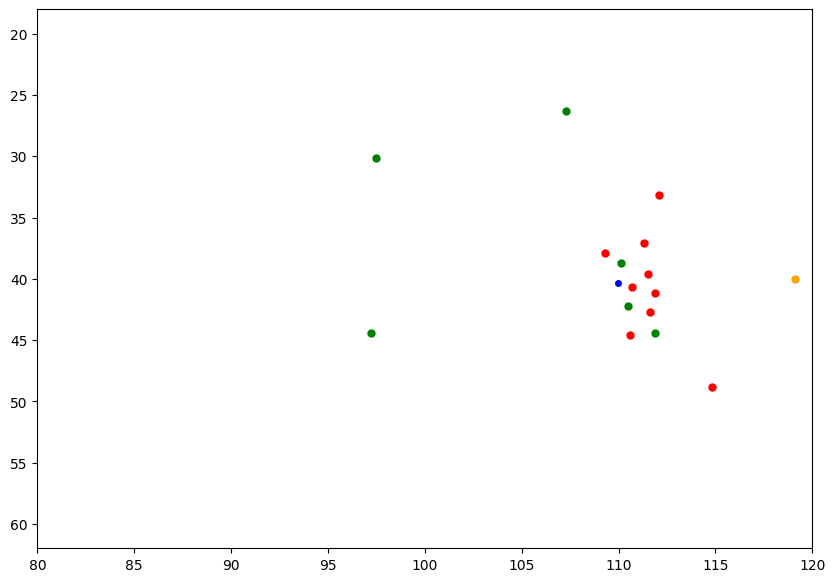

In [74]:
i = 373
row = df.iloc[i]

likelihood = get_block_likelihood(
    Point(row.coordinates_x, row.coordinates_y),
    row.freeze_frame,
    uniform_block_function(),
)
print(likelihood)


fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot([row.coordinates_x], [row.coordinates_y], color="blue", marker="o", ms=4)
for player_data in row.freeze_frame:
    color = "green"
    if player_data["position"]["name"] == "Goalkeeper":
        color = "orange"
    elif player_data["teammate"] is False:
        color = "red"
    ax.plot([player_data["location"][0]], [player_data["location"][1]], color=color, marker="o", ms=5)
    
ax.set_xlim(80, 120)
ax.set_ylim(62, 18)

In [75]:
block_info.iloc[i]["raw_event"]

{'id': '73308497-19d1-4f91-90e8-71337c25166d',
 'index': 1583,
 'period': 1,
 'timestamp': '00:42:50.814',
 'minute': 42,
 'second': 50,
 'type': {'id': 16, 'name': 'Shot'},
 'possession': 81,
 'possession_team': {'id': 783, 'name': 'Uruguay'},
 'play_pattern': {'id': 2, 'name': 'From Corner'},
 'team': {'id': 783, 'name': 'Uruguay'},
 'player': {'id': 5249, 'name': 'Diego Roberto Godín Leal'},
 'position': {'id': 3, 'name': 'Right Center Back'},
 'location': [110.0, 40.4],
 'duration': 0.633348,
 'under_pressure': True,
 'related_events': ['a319f2a4-bf8f-4675-adc3-441843c258ff',
  'eb83b12a-6982-42da-b4e1-c63872230d58'],
 'shot': {'statsbomb_xg': 0.054689027,
  'end_location': [120.0, 36.0, 1.0],
  'key_pass_id': 'bbbcdb71-9859-4910-8e0c-2f2d64eb4580',
  'type': {'id': 87, 'name': 'Open Play'},
  'outcome': {'id': 99, 'name': 'Post'},
  'technique': {'id': 93, 'name': 'Normal'},
  'aerial_won': True,
  'body_part': {'id': 37, 'name': 'Head'},
  'freeze_frame': [{'location': [114.6, 78

## Unusual shots 
_(Note: minute markers refer to the minute that ticked over already, which is different from how time is normally discussed in soccer. Here, a block that occurred at 29 minutes and 30 seconds would be in the 29th minute, where normally it would be recorded as occurring in the 30th minute.)_

### Blocked shots that shouldn't have been

* iloc 245/722: A slower shot from a highly oblique angle is blocked by a player who is not in a blocking position when the shot is made but is in a blocking position by the time the ball gets to the goal. (US versus Netherlands, 74th minute; South Korea vs Ghana, 75th minute)
* iloc 747: Similar to the above, this one is a chip around the goalie that moves slow enough for a defender to get back in time to clear (Ghana vs Uruguay, 22nd minute)

For these shots, there is probably nothing that can be improved on based on these data. If there was player speed/direction data it might be possible to skew the blockable area calculation to account for that, but even then it's going to be very difficult to also account for whether or not the shot will be a slow one.

* iloc 9: A defender is very close to the shooter and is able to block the shot, even though the position data indicates that they are out of position (Australia vs France, 36th minute)
* iloc 682: There are several defenders right on the edge of the shot envelope, and the shot is from relatively far away. The shot ends up being basically right at one of the defenders who heads it down (Spain vs Japan, 79th minute)
* iloc 536: A shot from distance, likely trying to be curled into the top corner, is blocked by a player covering the right side of the shot paths. Basically the shot may not have been quite on goal when it was fired but would have potentially curled in (Wales vs England, 23rd minute)
* iloc 850: A shot from distance that was probably not going to be on target is blocked by a player not really standing in front of goal (Costa Rica vs Japan, 34th minute)
* iloc 737: Similar to the above (Wales vs US, 60th minute)

There may be ways to finesse the block score for these cases, e.g. raise the offset for players very close to the shooter or bump up the block score for cases where a shot is from far away and a defender is in front of the side of the net (ie covering an area that the long-range shooter must target in order to beat the goalkeeper from that distance). Or potentially extending the allowed shot angles when the shot is far from goal to account for the ball being curled or the shot being off-target.

* iloc 149: Similar to 682 with a few potential defenders in the way. In this case, however, the shot is not so much blocked as it is deflected and actually ends up **in the goal**. 

This seems like a data error.

### Unblocked shots that should have been blocked
* iloc 33: Free kick, shot over the net (Brazil vs Cameroon, 33rd minute)
* iloc 765: Free kick, shot saved (Ghana vs Uruguay, 99th minute)

Need to make sure that shot type is included

* iloc 482: Long shot with a bunch of defenders in the way, substantially off-target (Canada vs Croatia, 76th minute)

Probably nothing that can be done here, the shot's likely to miss anyway

* iloc 373: Jumping header off a corner gets over a bunch of nearby defenders

Maybe need to account for body part == head, or use the 'aerial_won' parameters